# From LM-GC Plasticity Model to CAN model of Grid cells
The Toy Plasticity Model was an auto-associative $1D$ model whose goal was to:
- Give the system a LM unit that is able to recognize periodicity and phase of landmarks
- Learns the GC frequencies / phases matching external rhythm
- Generates internal landmark drive even when external signal is not visible

In other words, LM teaches the brain which internal module has the correct frequency and which phase in that model aligns with the external landmark, and after learning, LM can fire at the right times even without sensory landmarks.

### Given that an internal landmark signal exists, how does it shape the dynamics of a CAN and the variability of timing?
The goal of the CAN model is to show the effects of endogenous landmarks on **path integration** and **timing** and **simulate the post-learning scenario**.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from typing import Tuple

## 0. CAN Model - Conceptual description
The CAN model is a **$1D$ continuous attractor network that**
- maintains a **single activity bump** on a ring of neurons
- moves this bump smoothly along the ring according to a **noisy velocity input** (path integration)
- keeps the bump rigid (preserves shape, only translates it around the ring)
- optionally receives **internal landmark inputs** at specific phases on the ring
- produces bump trajectories and reaction times (time to reach an end phase)

# 1. Network architecture
We model a single module (the LM-matched module) as an independent ring attractor.

- ### Left and Right populations
    Given a number of neurons $K$ ( e.g. $360$):\
    it is made by 2 populations *(L)* and *(R)* forming one unified ring, representing two directionally biased copies of the same $1D$ ring.
    - Right population (R): neurons $1, \dots, K$
    - Left population (L): neurons $K+1, \dots, 2K$

    The total number of neurons is then $2K$.

- ### Mexican-hat connectivity matrix (Difference of Gaussians)
    We define a 1D lateral connectivity kernel on the ring

    $\text{MexHat}[k] = A_{\text{exc}}\exp(-s_{\text{exc}}z^2_k) - A_{\text{inh}}\exp(-s_{\text{inh}}z^2_k)$

    - $z_k \in \{-\frac{K}{2}, \dots, \frac{K}{2}-1\}$ is the circular distance
    - $A_{\text{exc}}$, $A_{\text{inh}}$ are amplitudes
    - $s_{\text{exc}}$, $s_{\text{inh}}$ are control widths

    This kernel has:
    - local excitation (narrow Gaussian)
    - broader inhibition (larger Gaussian)

    It ensures a **single stable bump** and is built such that **neighbours excite neighbours**:
    - Neurons near bump center must excite each other to maintain bump height
    - Neurons far away must inhibit each other to prevent multiple bumps from appearing

- ### Directionally biased synapses

    We build four $K \times K$ weight matrices such that each row defines **incoming** weights onto neuron $i$:
    - **2 Directional**: they create a **bump drift** (clockwise for right direction, counterclockwise for left)
        - $W_{RR}$: Right $\mapsto$ Right
        - $W_{LL}$: Left $\mapsto$ Left

        They 
    - 2 coupling the two populations: enforce a single bump is shared between L and R
        - $W_{RL}$: Right $\mapsto$ Left
        - $W_{LR}$: Left $\mapsto$ Right
    
    This makes the model a continuous attractor network with **direction selectivity**
    

- ### Initialization parameters:

    Initiate class CAN_Network using structural parameters, which follow *Burak & Fiete (2009)*
    - $K$: (364) number of ring neurons

    - Numerics: 
        - $dt$: step size of numerical integration (s)
        - $\tau_s$: synaptic time constant (s)

    - Drive    
        - $\beta_{\text{vel}}$: gain on velocity input (controls how strongly the bump moves per unit velocity)
        - $\beta_0$: global feedforward excitatory drive amplitude (sets how excitable the network is)
    
    - mexhat: built using connectivity shape parameters: 
        - $A_{\text{exc}}$, $A_{\text{inh}}$ 
        - $s_{\text{exc}}$, $s_{\text{inh}}$

*RK)* the paper doesn't go parameter-by-parameter with biological justification. They say that the CAN was adapted from *Burak & Fiete* + they did grid searches over velocity to match the behavioral periodicity and ensure robustness across Weber fractions

Eg. $\beta_{\text{vel}}$ was calibrated so that with the chosen speeds $\text{wolm}$ $\text{wlm}$ the model reproduces the $\sim 0.65s$ periodicity and matched mean time to target

In [30]:
class CANNetwork:
    """
    1D Continuous Attractor Network (single module, two populations: Right & Left)
    Defines the architecture and the static parameters

    Attributes
    ----------
    K : int
        Number of neurons per ring (Right and Left populations each have N neurons).
        Total neurons = 2K.
    dt : float
        Integration time step (seconds).
    tau_s : float
        Synaptic time constant (seconds).
    beta_0 : float
        Global feedforward excitatory drive amplitude.
    beta_vel : float
        Gain on velocity input.
    
        
    mex_hat : np.ndarray, shape (N,)
        Base mexican-hat connectivity kernel on the ring.
    W_RR, W_LL, W_RL, W_LR : np.ndarray, shape (N, N)
        Synaptic weight matrices between populations:
        - W_RR: Right -> Right (shifted kernel, one direction)
        - W_LL: Left  -> Left  (shifted kernel, opposite direction)
        - W_RL: Left  -> Right (no shift)
        - W_LR: Right -> Left  (no shift)
    FF_global : np.ndarray, shape (N,)
        Constant feedforward input to each neuron in each population.
    """

    def __init__(
        self, 
        K: int,
        dt: float = 1.0 / 2000.0,
        tau_s: float = 40.0 / 1000.0, #(40 ms)
        beta_vel: float = 1.0, 
        beta_0: float = 100.0,
        ):

        self.K = K
        self.dt = dt
        self.tau_s = tau_s
        self.beta_vel = beta_vel
        self.beta_0 = beta_0

        # Global feedforward excitation
        self.FF_global = self.beta_0 * np.ones(self.K, dtype= float)

        # Build connectivity
        self.mexhat = self.build_mexhat()
        self.W_RR, self.W_LL, self.W_RL, self.W_LR = self.build_synapses()

    
    def build_mexhat(
            self,
            A_exc: float = 1000.0,
            s_exc: float = 1.05 / 100.0,
            A_inh: float = 1000.0,
            s_inh: float = 1.00 / 100.0
            ) -> np.array:
        z = np.arange(-self.K/2, self.K/2, 1.0)
        mex = A_exc * np.exp(-s_exc * z**2) - A_inh * np.exp(-s_inh * z**2)

        #circshitft by N/2 -1
        shift = int(self.K/2 -1)
        mex = np.roll(mex, shift)
        return mex.astype(float)
    

    def build_synapses(self) -> Tuple[np.array, np.array, np.array, np.array]:
        # returns (W_RR, W_LL, W_RL, W_LL)
        W_RR = np.zeros((self.K, self.K), dtype=float)
        W_LL = np.zeros((self.K, self.K), dtype=float)
        W_RL = np.zeros((self.K, self.K), dtype=float)
        W_LR = np.zeros((self.K, self.K), dtype=float)

        for i in range(self.K):
            # indexing 0, ..., K-1
            W_RR[i, :] = np.roll(self.mexhat, i-1)
            W_LL[i, :] = np.roll(self.mexhat, i+1)
            W_RL[i, :] = np.roll(self.mexhat, i)
            W_LR[i, :] = np.roll(self.mexhat, i)
        
        return W_RR, W_LL, W_RL, W_LR


# 2. CAN Simulation

- ### Task-specific parameters:
    - $\text{wolm\_speed}$
    - $\text{wlm\_speed}$
    - $\text{wm}$
    - $\text{landmark\_loc}$


- ### Initialization
    It is a $10s$ dynamics that is not modeling sensory landmarks, but it is stabilizing the network into a proper attractor bump before the task begins.
    - No task stimuli
    - No learned landmarks
    - No external cues
    - Just initialize the bump attractor to a stable state

    **Biological interpretation**: In the brain, grid-cell attractor dynamics don’t start from random noise at the beginning of every trial — they are already in a stable state from previous activity. 

    The “landmark” here is just a weak Gaussian to ensure the bump starts somewhere predictable.

- ### During run_trial (CAN model)
    - The subject performs the internal timing task.
    - Landmarks do not correspond to external stimuli (there are no external cues in the reproduction phase)
    - Only internal landmark triggers (if landmarkpresent=True), and they are triggered by the bump reaching certain internal phases.
    - These internal triggers reduce drift variance and explain the periodicity seen in behavior.


In [31]:
netw = CANNetwork(K=10)

In [41]:
class CANSimulator:
    """
    Simulator class for CAN dynamics

    Contains:
        - init_state:
            Classic ring attractor with asymmetric connectivity. Ceates a moving bump of grid-cell activity that represents elapsed path distance.
        - run_trial
            The bump moves clockwise or counterclockwise according to the noisy velocity input and its direction
            Can include internal triggers after learning internal landmarks, or can run witout landmarks (a bump forms spontaneously and drifts according to v(t))
    """

    def __init__(self, network:CANNetwork):
        self.network = network
    

    def generate_landmark_input(self, centers, std, ampl_scaling, normalize_single=False):
        """
        Produces the total landmark input across K ring neurons
        Later, it will be added to the neural input to stabilize the bump

        Parameters:
        ----------
        - centers: list or array of length L
            Landmark centers, expressed as neuron indices in 1, ..., K (the phases at which landmarks are shown)
        - std:
            standard dev of each Gaussian bump
        - ampl_scaling:
            amplitude scaling of the landmark input
        - normalize_single: bool
            if True and L == 1, normalize the peak of the Gaussian to 1 before scaling by ampl_scaling parameter
        
            
        Returns:
        -------
        landmark_input: np.array of shape (K,)
            The total landmark drive to each of the K neurons
        
        """
        K = self.network.K
        L = len(centers)

        # row vector of L centers (shape (1, L)
        centers_row = np.atleast_1d(centers).astype(float).reshape(1, L)
        
        # column vector of K indices (from 1 to K)
        x_col = np.arange(1, K+1, dtype=float).reshape(K,1)

        # For each neuron i and each landmark l:
        #   gauss[i, l] = exp( - (i - center_l)^2 / (2 * std^2) )
        #   gaussian_matr has shape (K, L)
        gaussian_matr = np.exp(-(x_col-centers_row)**2 / (2.0 * std**2))

        if normalize_single and L==1:
            gaussian_matr = gaussian_matr / gaussian_matr.max()
        
        landmark_input = ampl_scaling * gaussian_matr.sum(axis=1)
        return landmark_input

In [65]:
K = 10
netw = CANNetwork(K)
model = CANSimulator(netw)

In [68]:
landm_input = model.generate_landmark_input(
    centers= [1, 8],
    std= 2.0,
    ampl_scaling = 10.0)

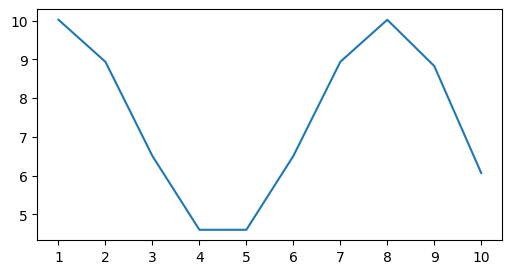

In [69]:
plt.figure(figsize = (6,3))
plt.plot(np.arange(1, K+1), landm_input)
plt.xticks(np.arange(1, K+1))
plt.show()